# Acoustic Anomaly Detection with Azure Machine Learning
## 9. Batch Audio Features Extraction using Librosa

<img src="https://github.com/retkowsky/Audio_Analytics_With_AzureML/raw/main/image.jpg" width = 800>

<div class="alert alert-info"><b> Let's do the audio features extraction for all the files in a directory. Then we will use AutoML using all these features</b></div>

Serge Retkowsky | serge.retkowsky@microsoft.com | 31-May-2022 | V2

In [1]:
import datetime
import numpy as np
import pandas as pd
import scipy
import librosa
import librosa.display
import IPython
from pathlib import Path

In [2]:
import sys
sys.version

'3.8.5 (default, Sep  4 2020, 07:30:14) \n[GCC 7.3.0]'

In [3]:
print(datetime.datetime.now())

2022-05-31 09:21:04.486496


In [4]:
def dirfiles(mypath):
    
    print("Total of files in", mypath, "=", sum(len(files) for _, _, files in os.walk(mypath)), '\n')
    
    for root, _, files in os.walk(mypath):
        print(root, ":", len(files), "files")

## 1. Directory to use to generate audio features for each file

In [5]:
AUDIOFILES_DIR = "soundssamples"

In [6]:
dirfiles(AUDIOFILES_DIR)

Total of files in soundssamples = 122 

soundssamples : 0 files
soundssamples/KO : 61 files
soundssamples/OK : 61 files


## 2. Directory to save the results

In [7]:
FEATURES_DIR = 'features'

if Path(FEATURES_DIR).is_dir() == True:
    os.rmdir(FEATURES_DIR)
    print("Deleting previous directory...")
    os.mkdir(FEATURES_DIR)
    print("Directory is created")
    
if Path(FEATURES_DIR).is_dir() == False:
    os.mkdir(FEATURES_DIR)
    print("Directory is created")

dirfiles(FEATURES_DIR)

Directory is created
Total of files in features = 0 

features : 0 files


## 3. Function to extract audio features

In [8]:
def audiofeaturesextraction(audio):
    
    print(datetime.datetime.now(), "Generating audio features extraction from:", audio)
    
    # Getting some file infromations
    basename = os.path.basename(audio)
    basenamewithoutext = os.path.splitext(basename)[0]
    extension = os.path.splitext(audiofilelocation)[1][1:]
    fullfilename = audiofilelocation
    dirsname = os.path.dirname(audio)
    category = dirsname.split("/",1)[1]

    basename_df = pd.DataFrame({'filename': [basename]})
    basenamewithoutext_df = pd.DataFrame({'basename': [basenamewithoutext]})
    ext_df = pd.DataFrame({'extension': [extension]})
    dirsname_df = pd.DataFrame({'dirsname': [dirsname]})
    fullfilename_df = pd.DataFrame({'fullfilename': [fullfilename]})
    category_df = pd.DataFrame({'category': [category]})
    
    # dataframe with filename and directory information
    filename_df = pd.concat([fullfilename_df, dirsname_df, category_df, basename_df, 
                             basenamewithoutext_df, ext_df], axis = 1)
    
    # Loading sound file
    y, sr = librosa.load(audio)
    
    # Harmonic & percussive
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    tempo, beat_frames = librosa.beat.beat_track(y = y_harmonic, sr = sr)
    
    # Chroma
    chroma = librosa.feature.chroma_cens(y = y_harmonic, sr = sr)
    chroma_mean = np.mean(chroma, axis = 1)
    chroma_std = np.std(chroma, axis = 1)
    octave = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']
    
    chroma_df = pd.DataFrame()

    for i in range(0, 12):
        chroma_df['chroma_mean_' + str(i)] = chroma_mean[i]

    for i in range(0, 12):
        chroma_df['chroma_std_' + str(i)] = chroma_mean[i]
    
    chroma_df.loc[0] = np.concatenate((chroma_mean, chroma_std), axis = 0)
    
    # MFCCS
    mfccs = librosa.feature.mfcc(y = y_harmonic, sr = sr, n_mfcc = 13)
    mfccs_mean = np.mean(mfccs, axis = 1)
    mfccs_std = np.std(mfccs, axis = 1)
    coeffs = np.arange(0, 13)

    mfccs_df = pd.DataFrame()
    
    for i in range(0 ,13):
        mfccs_df['mfccs_mean_'+str(i)] = mfccs_mean[i]

    for i in range(0, 13):
        mfccs_df['mfccs_std_'+str(i)] = mfccs_mean[i]
        
    mfccs_df.loc[0] = np.concatenate((mfccs_mean, mfccs_std), axis = 0)
    
    # Cent
    cent = librosa.feature.spectral_centroid(y = y, sr = sr)
    cent_mean = np.mean(cent)
    cent_std = np.std(cent)
    cent_skew = scipy.stats.skew(cent, axis = 1)[0]

    # Contrast
    contrast = librosa.feature.spectral_contrast(y = y_harmonic, sr = sr)
    contrast_mean = np.mean(contrast, axis = 1)
    contrast_std = np.std(contrast, axis = 1)
    conts = np.arange(0, 7)
    contrast_df = pd.DataFrame()

    # rolloff
    rolloff = librosa.feature.spectral_rolloff(y = y, sr = sr)
    rolloff_mean = np.mean(rolloff)
    rolloff_std = np.std(rolloff)
    rolloff_skew = scipy.stats.skew(rolloff, axis = 1)[0]

    spectral_df = pd.DataFrame()
    collist = ['cent_mean','cent_std','cent_skew']

    for i in range(0, 7):
        collist.append('contrast_mean_' + str(i))

    for i in range(0, 7):
        collist.append('contrast_std_' + str(i))
        
    collist = collist + ['rolloff_mean','rolloff_std','rolloff_skew']
    
    for c in collist:
        spectral_df[c] = 0
    
    data=np.concatenate(([cent_mean, cent_std, cent_skew], contrast_mean, contrast_std,
                         [rolloff_mean, rolloff_std, rolloff_std]), axis = 0)
    spectral_df.loc[0] = data
    
    # zrate
    zrate = librosa.feature.zero_crossing_rate(y_harmonic)
    zrate_mean = np.mean(zrate)
    zrate_std = np.std(zrate)
    zrate_skew = scipy.stats.skew(zrate, axis = 1)[0]
    zrate_df = pd.DataFrame()
    zrate_df['zrate_mean'] = 0
    zrate_df['zrate_std'] = 0
    zrate_df['zrate_skew'] = 0
    zrate_df.loc[0] = [zrate_mean,zrate_std,zrate_skew]

    # beat
    beat_df = pd.DataFrame()
    beat_df['tempo'] = tempo
    beat_df.loc[0] = tempo

    # Additional informations
    sr_df = pd.DataFrame({'sampling_rate': [sr]})
    totalsamples = np.size(y)
    duration = totalsamples / sr
    totalsamples_df = pd.DataFrame({'total_samples': [totalsamples]})
    duration_df = pd.DataFrame({'duration': [duration]})

    # Saving audiofeatures to a dataframe
    audiofeatures_df = pd.concat((chroma_df, mfccs_df, spectral_df, zrate_df, beat_df), axis = 1)
    
    # Saving all results into a single dataframe
    filesaudio_df = pd.concat([filename_df, sr_df, totalsamples_df, duration_df, audiofeatures_df], axis = 1)
    
    # Export to CSV for each audio file
    outputfile = FEATURES_DIR + '/' + basenamewithoutext + '_features.csv'
    filesaudio_df.to_csv(outputfile)

## 4. Let's run the function to extract audio features for each file

In [9]:
start = datetime.datetime.now()

print(start, 'Audio Features extraction...\n')

for root, dirs, files in os.walk(AUDIOFILES_DIR):
    
    for audiofile in files:
        audiofilelocation = root + '/' + audiofile
        audiofeaturesextraction(audiofilelocation)

end = datetime.datetime.now()
print('\n', end, 'End of job. Processing time:', end - start)

2022-05-31 09:21:29.947518 Audio Features extraction...

2022-05-31 09:21:30.019915 Generating audio features extraction from: soundssamples/KO/machine_KO_1.wav
2022-05-31 09:21:32.176368 Generating audio features extraction from: soundssamples/KO/machine_KO_10.wav
2022-05-31 09:21:33.647075 Generating audio features extraction from: soundssamples/KO/machine_KO_11.wav
2022-05-31 09:21:35.012752 Generating audio features extraction from: soundssamples/KO/machine_KO_12.wav
2022-05-31 09:21:36.483193 Generating audio features extraction from: soundssamples/KO/machine_KO_13.wav
2022-05-31 09:21:37.913144 Generating audio features extraction from: soundssamples/KO/machine_KO_14.wav
2022-05-31 09:21:39.345006 Generating audio features extraction from: soundssamples/KO/machine_KO_15.wav
2022-05-31 09:21:40.721737 Generating audio features extraction from: soundssamples/KO/machine_KO_16.wav
2022-05-31 09:21:42.148416 Generating audio features extraction from: soundssamples/KO/machine_KO_17.wav

2022-05-31 09:23:21.897809 Generating audio features extraction from: soundssamples/OK/machine_OK_25.wav
2022-05-31 09:23:23.398985 Generating audio features extraction from: soundssamples/OK/machine_OK_26.wav
2022-05-31 09:23:24.905890 Generating audio features extraction from: soundssamples/OK/machine_OK_27.wav
2022-05-31 09:23:26.291968 Generating audio features extraction from: soundssamples/OK/machine_OK_28.wav
2022-05-31 09:23:27.712668 Generating audio features extraction from: soundssamples/OK/machine_OK_29.wav
2022-05-31 09:23:29.111432 Generating audio features extraction from: soundssamples/OK/machine_OK_3.wav
2022-05-31 09:23:30.505866 Generating audio features extraction from: soundssamples/OK/machine_OK_30.wav
2022-05-31 09:23:32.133894 Generating audio features extraction from: soundssamples/OK/machine_OK_31.wav
2022-05-31 09:23:33.584657 Generating audio features extraction from: soundssamples/OK/machine_OK_32.wav
2022-05-31 09:23:34.999243 Generating audio features ext

## 5. Results

In [10]:
dirfiles(FEATURES_DIR)

Total of files in features = 122 

features : 122 files


In [11]:
os.chdir(FEATURES_DIR)

filepaths = [f for f in os.listdir() if f.endswith('.csv')] # Taking all the CSV files into a single dataframe
audiofeaturesdf = pd.concat(map(pd.read_csv, filepaths))

del audiofeaturesdf['Unnamed: 0'] # Cleaning the df
audiofeaturesdf = audiofeaturesdf.reset_index(drop = True) # Clean index

os.chdir('..')

In [12]:
audiofeaturesdf.head(10)

,fullfilename,dirsname,category,filename,basename,extension,sampling_rate,total_samples,duration,chroma_mean_0,...,contrast_std_4,contrast_std_5,contrast_std_6,rolloff_mean,rolloff_std,rolloff_skew,zrate_mean,zrate_std,zrate_skew,tempo
0,soundssamples/KO/machine_KO_10.wav,soundssamples/KO,KO,machine_KO_10.wav,machine_KO_10,wav,22050,154350,7.0,0.207503,...,1.687249,1.348917,1.956130,4519.334482,440.507933,440.507933,0.042180,0.007172,0.254478,89.102909
1,soundssamples/KO/machine_KO_11.wav,soundssamples/KO,KO,machine_KO_11.wav,machine_KO_11,wav,22050,154350,7.0,0.254620,...,1.659869,1.223647,1.890165,4615.663480,400.850709,400.850709,0.044206,0.007007,-0.040588,89.102909
2,soundssamples/KO/machine_KO_12.wav,soundssamples/KO,KO,machine_KO_12.wav,machine_KO_12,wav,22050,154350,7.0,0.209314,...,1.754098,1.625430,1.688382,4621.011130,535.484051,535.484051,0.044763,0.008382,0.570683,89.102909
3,soundssamples/KO/machine_KO_13.wav,soundssamples/KO,KO,machine_KO_13.wav,machine_KO_13,wav,22050,154350,7.0,0.256801,...,1.821550,1.315156,1.914569,4550.315200,513.303975,513.303975,0.044505,0.007688,0.149309,129.199219
4,soundssamples/KO/machine_KO_14.wav,soundssamples/KO,KO,machine_KO_14.wav,machine_KO_14,wav,22050,154350,7.0,0.260920,...,1.809823,1.435966,2.025108,4610.993200,444.503034,444.503034,0.045001,0.007708,0.176262,89.102909
5,soundssamples/KO/machine_KO_15.wav,soundssamples/KO,KO,machine_KO_15.wav,machine_KO_15,wav,22050,154350,7.0,0.250668,...,1.590028,1.412380,1.944300,4740.263720,442.059842,442.059842,0.047003,0.007652,0.178112,172.265625
6,soundssamples/KO/machine_KO_16.wav,soundssamples/KO,KO,machine_KO_16.wav,machine_KO_16,wav,22050,154350,7.0,0.212568,...,1.730300,1.322666,2.102655,4677.553614,509.905473,509.905473,0.044823,0.008664,-0.045291,89.102909
7,soundssamples/KO/machine_KO_17.wav,soundssamples/KO,KO,machine_KO_17.wav,machine_KO_17,wav,22050,154350,7.0,0.254024,...,1.723419,1.283005,2.005421,4627.321357,483.232189,483.232189,0.040818,0.007485,0.416858,89.102909
8,soundssamples/KO/machine_KO_18.wav,soundssamples/KO,KO,machine_KO_18.wav,machine_KO_18,wav,22050,154350,7.0,0.295817,...,1.734805,1.301384,1.926679,4747.536524,488.871213,488.871213,0.046126,0.008686,-0.125855,89.102909
9,soundssamples/KO/machine_KO_19.wav,soundssamples/KO,KO,machine_KO_19.wav,machine_KO_19,wav,22050,154350,7.0,0.204857,...,1.736444,1.416731,1.924551,4881.441675,378.570715,378.570715,0.046741,0.008679,0.278751,89.102909


In [13]:
audiofeaturesdf.shape

(122, 83)

In [14]:
audiofeaturesdf.columns

Index(['fullfilename', 'dirsname', 'category', 'filename', 'basename',
       'extension', 'sampling_rate', 'total_samples', 'duration',
       'chroma_mean_0', 'chroma_mean_1', 'chroma_mean_2', 'chroma_mean_3',
       'chroma_mean_4', 'chroma_mean_5', 'chroma_mean_6', 'chroma_mean_7',
       'chroma_mean_8', 'chroma_mean_9', 'chroma_mean_10', 'chroma_mean_11',
       'chroma_std_0', 'chroma_std_1', 'chroma_std_2', 'chroma_std_3',
       'chroma_std_4', 'chroma_std_5', 'chroma_std_6', 'chroma_std_7',
       'chroma_std_8', 'chroma_std_9', 'chroma_std_10', 'chroma_std_11',
       'mfccs_mean_0', 'mfccs_mean_1', 'mfccs_mean_2', 'mfccs_mean_3',
       'mfccs_mean_4', 'mfccs_mean_5', 'mfccs_mean_6', 'mfccs_mean_7',
       'mfccs_mean_8', 'mfccs_mean_9', 'mfccs_mean_10', 'mfccs_mean_11',
       'mfccs_mean_12', 'mfccs_std_0', 'mfccs_std_1', 'mfccs_std_2',
       'mfccs_std_3', 'mfccs_std_4', 'mfccs_std_5', 'mfccs_std_6',
       'mfccs_std_7', 'mfccs_std_8', 'mfccs_std_9', 'mfccs_std_10',
  

In [15]:
audiofeaturesdf.describe()

,sampling_rate,total_samples,duration,chroma_mean_0,chroma_mean_1,chroma_mean_2,chroma_mean_3,chroma_mean_4,chroma_mean_5,chroma_mean_6,...,contrast_std_4,contrast_std_5,contrast_std_6,rolloff_mean,rolloff_std,rolloff_skew,zrate_mean,zrate_std,zrate_skew,tempo
count,122.0,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,...,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000
mean,22050.0,153183.885246,6.947115,0.256008,0.096830,0.018883,0.005733,0.035323,0.214246,0.240696,...,1.707844,1.302797,1.810467,4789.858329,445.042850,445.042850,0.048709,0.008644,0.078444,108.043184
std,0.0,9069.934393,0.411335,0.031137,0.038384,0.012205,0.005535,0.029641,0.031067,0.047743,...,0.088831,0.075222,0.163460,137.453268,72.169106,72.169106,0.004015,0.001029,0.222126,32.150525
min,22050.0,83217.000000,3.774014,0.188875,0.004705,0.003091,0.000000,0.000000,0.134667,0.130089,...,1.507439,1.155628,1.439844,4450.599357,284.092321,284.092321,0.039979,0.006133,-0.430925,89.102909
25%,22050.0,154350.000000,7.000000,0.225710,0.067572,0.009924,0.001502,0.013512,0.193511,0.212933,...,1.656508,1.249630,1.706099,4694.175892,401.085128,401.085128,0.045954,0.007829,-0.074493,89.102909
50%,22050.0,154350.000000,7.000000,0.257555,0.102892,0.014943,0.003994,0.028536,0.210491,0.241342,...,1.705739,1.300568,1.840116,4784.470959,438.191109,438.191109,0.048901,0.008632,0.061557,89.102909
75%,22050.0,154350.000000,7.000000,0.283221,0.120734,0.023548,0.008489,0.048341,0.233583,0.259929,...,1.769227,1.345392,1.922908,4905.024810,488.555822,488.555822,0.051341,0.009294,0.236135,106.589355
max,22050.0,154350.000000,7.000000,0.307707,0.194028,0.068849,0.025453,0.124541,0.349846,0.359114,...,1.923569,1.625430,2.113547,5099.768390,626.771754,626.771754,0.060296,0.011756,0.823490,184.570312


In [16]:
audiofeaturesdf['category'].value_counts()

KO    61
OK    61
Name: category, dtype: int64

Text(0, 0.5, 'Number of files')

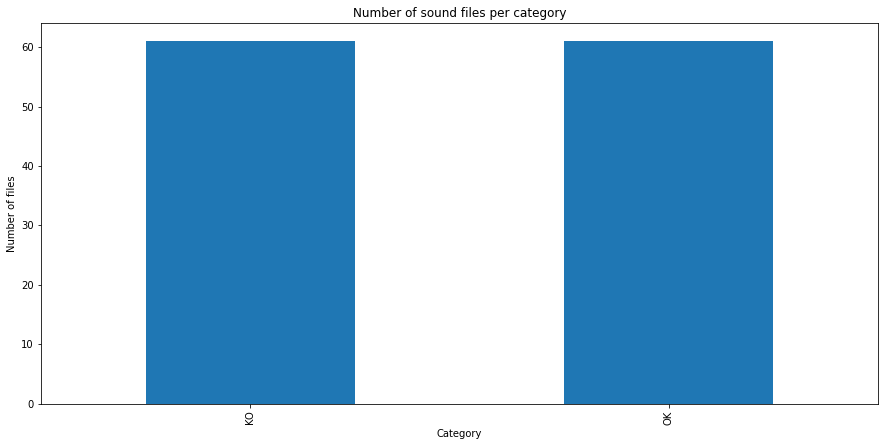

In [17]:
%matplotlib inline
ax = audiofeaturesdf['category'].value_counts().plot(kind = 'bar', 
                                                     figsize = (15, 7), 
                                                     title = "Number of sound files per category")
ax.set_xlabel("Category")
ax.set_ylabel("Number of files")

## 6. EDA

In [18]:
# Let's create a sample for the EDA

pctsample = 0.1
dfsample = audiofeaturesdf.sample(frac = pctsample)

In [19]:
dfsample.columns

Index(['fullfilename', 'dirsname', 'category', 'filename', 'basename',
       'extension', 'sampling_rate', 'total_samples', 'duration',
       'chroma_mean_0', 'chroma_mean_1', 'chroma_mean_2', 'chroma_mean_3',
       'chroma_mean_4', 'chroma_mean_5', 'chroma_mean_6', 'chroma_mean_7',
       'chroma_mean_8', 'chroma_mean_9', 'chroma_mean_10', 'chroma_mean_11',
       'chroma_std_0', 'chroma_std_1', 'chroma_std_2', 'chroma_std_3',
       'chroma_std_4', 'chroma_std_5', 'chroma_std_6', 'chroma_std_7',
       'chroma_std_8', 'chroma_std_9', 'chroma_std_10', 'chroma_std_11',
       'mfccs_mean_0', 'mfccs_mean_1', 'mfccs_mean_2', 'mfccs_mean_3',
       'mfccs_mean_4', 'mfccs_mean_5', 'mfccs_mean_6', 'mfccs_mean_7',
       'mfccs_mean_8', 'mfccs_mean_9', 'mfccs_mean_10', 'mfccs_mean_11',
       'mfccs_mean_12', 'mfccs_std_0', 'mfccs_std_1', 'mfccs_std_2',
       'mfccs_std_3', 'mfccs_std_4', 'mfccs_std_5', 'mfccs_std_6',
       'mfccs_std_7', 'mfccs_std_8', 'mfccs_std_9', 'mfccs_std_10',
  

In [20]:
dfsample.head()

,fullfilename,dirsname,category,filename,basename,extension,sampling_rate,total_samples,duration,chroma_mean_0,...,contrast_std_4,contrast_std_5,contrast_std_6,rolloff_mean,rolloff_std,rolloff_skew,zrate_mean,zrate_std,zrate_skew,tempo
68,soundssamples/OK/machine_OK_17.wav,soundssamples/OK,OK,machine_OK_17.wav,machine_OK_17,wav,22050,154350,7.0,0.260442,...,1.694869,1.245923,2.005953,4720.227859,328.702495,328.702495,0.040513,0.007528,0.313339,89.102909
54,soundssamples/KO/machine_KO_5.wav,soundssamples/KO,KO,machine_KO_5.wav,machine_KO_5,wav,22050,154350,7.0,0.304936,...,1.811450,1.361232,1.530161,4999.018668,549.908489,549.908489,0.053869,0.009491,-0.074722,89.102909
53,soundssamples/KO/machine_KO_59.wav,soundssamples/KO,KO,machine_KO_59.wav,machine_KO_59,wav,22050,154350,7.0,0.281076,...,1.685835,1.232497,1.499146,4903.509643,484.581162,484.581162,0.050558,0.010058,-0.288964,103.359375
48,soundssamples/KO/machine_KO_54.wav,soundssamples/KO,KO,machine_KO_54.wav,machine_KO_54,wav,22050,154350,7.0,0.277564,...,1.920923,1.225939,1.511190,4952.743672,491.984148,491.984148,0.051219,0.010139,-0.021527,172.265625
17,soundssamples/KO/machine_KO_26.wav,soundssamples/KO,KO,machine_KO_26.wav,machine_KO_26,wav,22050,154350,7.0,0.268844,...,1.809044,1.265688,1.939808,4700.405904,414.445814,414.445814,0.050599,0.007719,-0.140397,172.265625


In [21]:
dfsample.T

,68,54,53,48,17,21,39,2,11,74,14,33
fullfilename,soundssamples/OK/machine_OK_17.wav,soundssamples/KO/machine_KO_5.wav,soundssamples/KO/machine_KO_59.wav,soundssamples/KO/machine_KO_54.wav,soundssamples/KO/machine_KO_26.wav,soundssamples/KO/machine_KO_2.wav,soundssamples/KO/machine_KO_46.wav,soundssamples/KO/machine_KO_12.wav,soundssamples/KO/machine_KO_20.wav,soundssamples/OK/machine_OK_22.wav,soundssamples/KO/machine_KO_23.wav,soundssamples/KO/machine_KO_40.wav
dirsname,soundssamples/OK,soundssamples/KO,soundssamples/KO,soundssamples/KO,soundssamples/KO,soundssamples/KO,soundssamples/KO,soundssamples/KO,soundssamples/KO,soundssamples/OK,soundssamples/KO,soundssamples/KO
category,OK,KO,KO,KO,KO,KO,KO,KO,KO,OK,KO,KO
filename,machine_OK_17.wav,machine_KO_5.wav,machine_KO_59.wav,machine_KO_54.wav,machine_KO_26.wav,machine_KO_2.wav,machine_KO_46.wav,machine_KO_12.wav,machine_KO_20.wav,machine_OK_22.wav,machine_KO_23.wav,machine_KO_40.wav
basename,machine_OK_17,machine_KO_5,machine_KO_59,machine_KO_54,machine_KO_26,machine_KO_2,machine_KO_46,machine_KO_12,machine_KO_20,machine_OK_22,machine_KO_23,machine_KO_40
...,...,...,...,...,...,...,...,...,...,...,...,...
rolloff_skew,328.702495,549.908489,484.581162,491.984148,414.445814,626.771754,487.609648,535.484051,491.798572,437.505773,402.567901,512.996607
zrate_mean,0.040513,0.053869,0.050558,0.051219,0.050599,0.051761,0.051682,0.044763,0.04562,0.048582,0.047064,0.047902
zrate_std,0.007528,0.009491,0.010058,0.010139,0.007719,0.009609,0.00928,0.008382,0.00936,0.008288,0.007834,0.008346
zrate_skew,0.313339,-0.074722,-0.288964,-0.021527,-0.140397,-0.14708,-0.399912,0.570683,0.376199,-0.019997,0.104451,-0.173362


## 7. Export features to CSV

In [22]:
EXPORTFEATURES_DIR = 'featuresresults'

if Path(EXPORTFEATURES_DIR).is_dir() == False:
    os.mkdir(EXPORTFEATURES_DIR)
    print("Directory is created")

csv_output = EXPORTFEATURES_DIR + '/machineaudiofeatures.csv' # CSV filename to create

Directory is created


In [23]:
audiofeaturesdf.to_csv(csv_output)

In [26]:
!ls featuresresults/*.csv -lh

-rwxrwxrwx 1 root root 131K May 31 09:24 featuresresults/machineaudiofeatures.csv


In [24]:
from IPython.display import FileLink

CSVLINK = FileLink(path = csv_output)
print("Click to download the file:")
CSVLINK

Click to download the file:


/mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow8/code/Users/seretkow/MachineNoiseDetection/featuresresults/machineaudiofeatures.csv

> We will use AutoML for Classification in order to predict the music genre with the extracted features

Note: All these Python notebooks were made for demo purposes. They were not designed for production usage. Some feature can be currently in public preview. This preview version is provided without a service-level agreement. Certain features might not be supported or might have constrained capabilities. For more information, see Supplemental Terms of Use for Microsoft Azure Previews. https://azure.microsoft.com/en-us/support/legal/preview-supplemental-terms/